O modelo será capaz de classificar corretamente ou com menor erro possível as classes de gato e cachorro a partir de imagens.

O modelo será da categoria de aprendizado supervionado, porque sabemos a resposta de saída, no caso, gato ou cachorro.



Este novo experimento (model_3) visa melhorar o overfiting do modelo anterior (model_2), este overfiting pode ser visto pelo plot das métricas do experimento anterior.

Algumas formas de melhorar o overfiting que iremos usar aqui:

1. Usaremos uma camada de droupout. (Um dos motivos que podem levar um modelo ao overfiting é quando alguns parâmetros de alguma camada tem mais relevância na decisão e na privsão do que outros e isso é o que a camada de dropout tenta evitar. Adição desta camada vai literalmente "dropar" alguns parâmetros durante determinada fase do treinamento para equilibrar a relevância ou o peso da decisão de atualização de parâmetros entre todos os nós)
2. Usaremos Data Augmentation, que trocando em miúdos seria aumentar a quantidade de dados, rotacionando a imagens de várias maneiras ou até mesmo aplicando zoom nas imagens.
3. Usaremos uma técnica chamada de Transfer Leaning, que é a utilização de outro modelo, pré-treinado em uma grande quantidade de dados contendo camadas muito mais profundas que a nossa e com muito mais parâmetros configurados, como parte do nosso modelo. O tensorflow contém vários modelos pré-treinados e aqui faremos uso desta técnica. 

Import libs

In [18]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

Definindo os diretórios

In [19]:
#Definindo as variáveis que receberão os diretórios
dataset_dir = os.path.join(os.getcwd(), '/home/lume/Documents/code_cats_and_dogs/dataset/')

dataset_train_dir = os.path.join(dataset_dir, '/home/lume/Documents/code_cats_and_dogs/dataset/train_cats_and_dogs/')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, '/home/lume/Documents/code_cats_and_dogs/dataset/valid_cats_and_dogs/')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

#printando o quantitativo de imagens que cada pasta possui por classe
print('Train Cats: %s' % dataset_train_cats_len)
print('Train Dogs: %s' % dataset_train_dogs_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)

Train Cats: 10000
Train Dogs: 10000
Validation Cats: 2500
Validation Dogs: 2500


Agora é necessário pré-processar nossas imagens, pois não conseguimos trabalhar com binários de imagens, então definimos algumas configurações de entrada.

1. Tamanho = 160x160 (estratégia pode ser scaling da imagem, poderíamos pegar os primeiros 160x160 da imagem e ignorar o resto ou focar no centro da imagem e ignorar a periferia. O ideal é escolher com base nas nossas features dos dados). Escolherei scaling da imagem de 160x160.
2. Valor = No nosso caso vamos escolher a cor

In [20]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)

batch_size = 32 #quantidade de features trazidas por vez do meu dataset
epochs = 25 #n° de vezes que vou passar no meu dataset inteiro
learning_rate = 0.0001 #taxa de aprendizado

class_names = ['cat', 'dog'] #Como eu não gostaria de visualizar um número nas saídas então defino aqui uma string onde 0 =cat e 1=dog

Criando os datasets de treino, validação e teste baseado no tamanho do dataset de validação.

In [21]:
#image_dataset_from_directory retorna um objeto do tipo dataset baseado no path do argumento
#dataset de treinamento é usado para efetivamente atualizar os parâmetros da rede neural convolucional
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 20000 files belonging to 2 classes.


In [22]:
#image_dataset_from_directory retorna um objeto do tipo dataset baseado no path do argumento
#dataset de validação é usado para validar o modelo durante o treinamento, mas ele não é usado para atualização do modelo
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = (image_width, image_height),
    batch_size = batch_size,
    shuffle = True
)

Found 5000 files belonging to 2 classes.


In [23]:
#cria-se o dataset para teste ao final do treinamento
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation.take(dataset_validation_batches)
dataset_validation = dataset_validation.skip(dataset_validation_batches)

#print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
#print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))

In [24]:
autotune = tf.data.AUTOTUNE

dataset_train = dataset_train.prefetch(buffer_size = autotune)
dataset_validation = dataset_validation.prefetch(buffer_size = autotune)
dataset_test = dataset_validation.prefetch(buffer_size = autotune)

In [25]:
def plot_dataset(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, labels in dataset.take(1):

        for i in range(9):

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(features[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])

In [ ]:
#plot_dataset(dataset_train)

In [ ]:
#plot_dataset(dataset_validation)

In [ ]:
#plot_dataset(dataset_test)

Data Augmentation

In [26]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [27]:
def plot_dataset_data_augmentation(dataset):

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for features, _ in dataset.take(1):

        feature = features[0]

        for i in range(9):

            feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

            plt.subplot(3, 3, i + 1)
            plt.axis('off')

            plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

<Figure size 640x480 with 0 Axes>

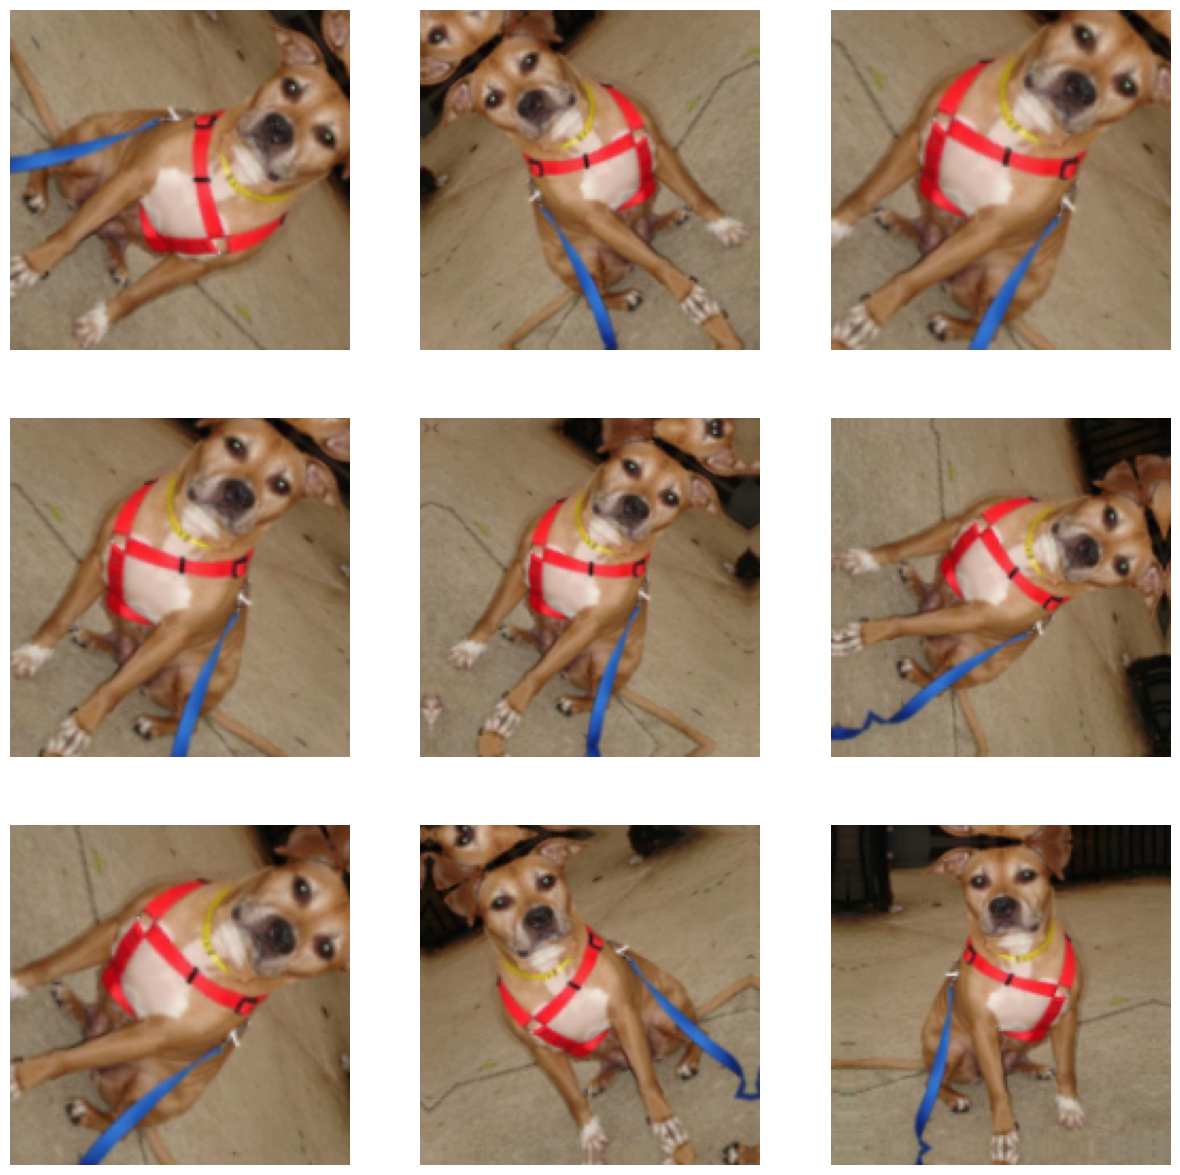

In [28]:
plot_dataset_data_augmentation(dataset_train)

Layer Rescaling

In [29]:
rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1. / (image_color_channel_size / 2.), offset = -1, input_shape = image_shape)

Transfer learning


In [30]:
model_transfer_learning = tf.keras.applications.MobileNetV2(input_shape = image_shape, include_top = False, weights = 'imagenet')
model_transfer_learning.trainable = False

model_transfer_learning.summary() #analisando um resumo do modelo

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Early stoping

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3)

Model

In [32]:
model = tf.keras.models.Sequential([
    rescaling,
    data_augmentation,
    model_transfer_learning,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [33]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs,
    callbacks = [
        early_stopping
    ]
)

df = pd.DataFrame.from_dict(history.history)
df.to_csv("/home/lume/Documents/code_cats_and_dogs/avaliação_model_3/" + "model_3.csv", index=False)

Epoch 1/25
625/625 [==============================] - 395s 610ms/step - loss: 0.4045 - accuracy: 0.8123 - val_loss: 0.1354 - val_accuracy: 0.9666
Epoch 2/25
625/625 [==============================] - 358s 572ms/step - loss: 0.2028 - accuracy: 0.9203 - val_loss: 0.0879 - val_accuracy: 0.9758
Epoch 3/25
625/625 [==============================] - 345s 553ms/step - loss: 0.1733 - accuracy: 0.9309 - val_loss: 0.0749 - val_accuracy: 0.9778
Epoch 4/25
625/625 [==============================] - 350s 560ms/step - loss: 0.1632 - accuracy: 0.9336 - val_loss: 0.0669 - val_accuracy: 0.9805
Epoch 5/25
625/625 [==============================] - 394s 631ms/step - loss: 0.1546 - accuracy: 0.9392 - val_loss: 0.0617 - val_accuracy: 0.9813
Epoch 6/25
625/625 [==============================] - 368s 588ms/step - loss: 0.1462 - accuracy: 0.9407 - val_loss: 0.0590 - val_accuracy: 0.9808
Epoch 7/25
625/625 [==============================] - 367s 586ms/step - loss: 0.1443 - accuracy: 0.9414 - val_loss: 0.0570 -

In [40]:
def plot_model():

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(19)

    plt.gcf().clear()
    plt.figure(figsize = (15, 8))

    plt.subplot(1, 2, 1)
    plt.title('Training and Validation Accuracy')
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')

    plt.subplot(1, 2, 2)
    plt.title('Training and Validation Loss')
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'lower right')

    plt.show()

<Figure size 640x480 with 0 Axes>

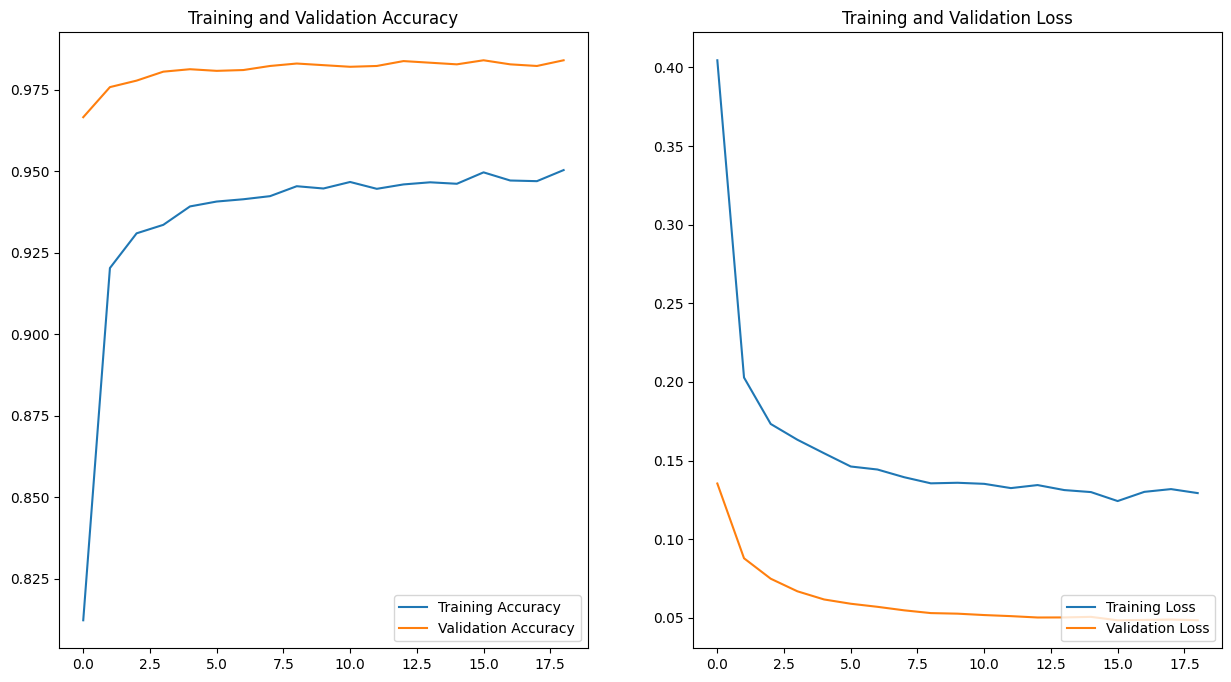

In [41]:
plot_model()

Model Evaluation

In [42]:
dataset_test_loss, dataset_test_accuracy = model.evaluate(dataset_test)

print('Dataset Test Loss:     %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

126/126 [==============================] - 22s 170ms/step - loss: 0.0490 - accuracy: 0.9833
Dataset Test Loss:     0.0489647313952446
Dataset Test Accuracy: 0.9832834601402283


In [43]:
def plot_dataset_predictions(dataset):

    features, labels = dataset_test.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(9):

        plt.subplot(3, 3, i + 1)
        plt.axis('off')

        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]])

Labels:      [1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1]
Predictions: [1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1]


<Figure size 640x480 with 0 Axes>

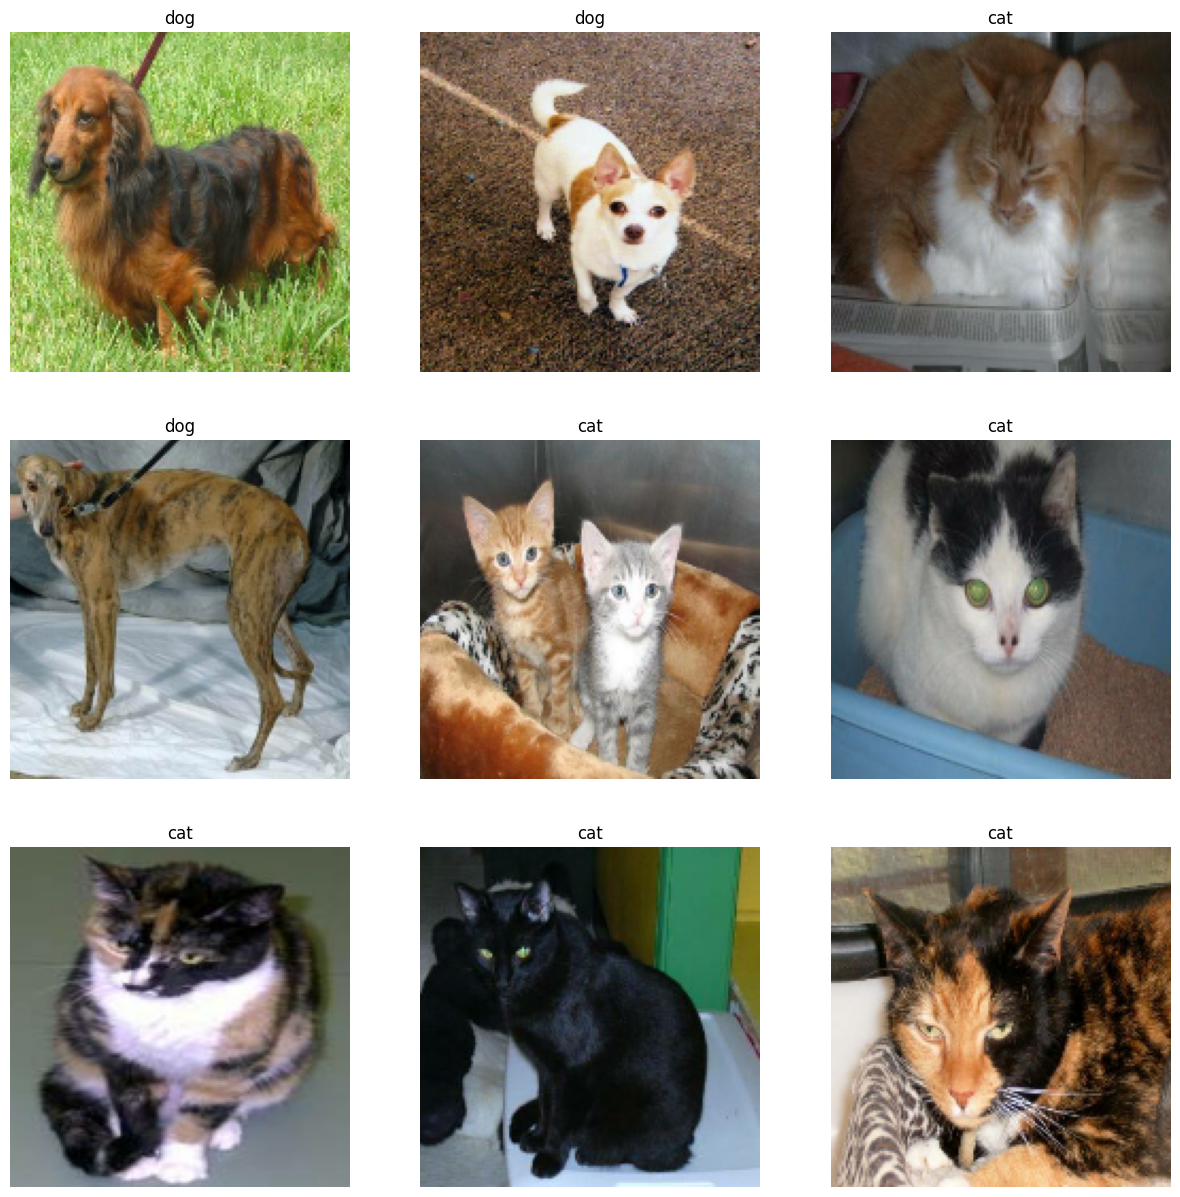

In [44]:
plot_dataset_predictions(dataset_test)

Save model

In [46]:
model.save('/home/lume/Documents/code_cats_and_dogs/avaliação_model_3/')

INFO:tensorflow:Assets written to: /home/lume/Documents/code_cats_and_dogs/avaliação_model_3/assets


INFO:tensorflow:Assets written to: /home/lume/Documents/code_cats_and_dogs/avaliação_model_3/assets


Predictions

In [47]:
def predict(image_file):

    image = tf.keras.preprocessing.image.load_img(image_file, target_size = image_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.expand_dims(image, 0)

    prediction = model.predict(image)[0][0]

    print('Prediction: {0} | {1}'.format(prediction, ('cat' if prediction < 0.5 else 'dog')))

In [51]:
predict('/home/lume/Documents/code_cats_and_dogs/avaliação_model_3/gato.jpeg')

1/1 [==============================] - 0s 488ms/step
Prediction: 0.00017996999667957425 | cat


In [54]:
predict('/home/lume/Documents/code_cats_and_dogs/avaliação_model_3/cachorro.jpg')

1/1 [==============================] - 0s 24ms/step
Prediction: 0.9851520657539368 | dog
